[bnlearn] >Import <asia>
[bnlearn] >Loading bif file </home/gulce/.pyenv/versions/3.11.7/lib/python3.11/site-packages/datazets/data/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Warning: [graphviz_layout] layout not found. The layout [spring_layout] is used instead.


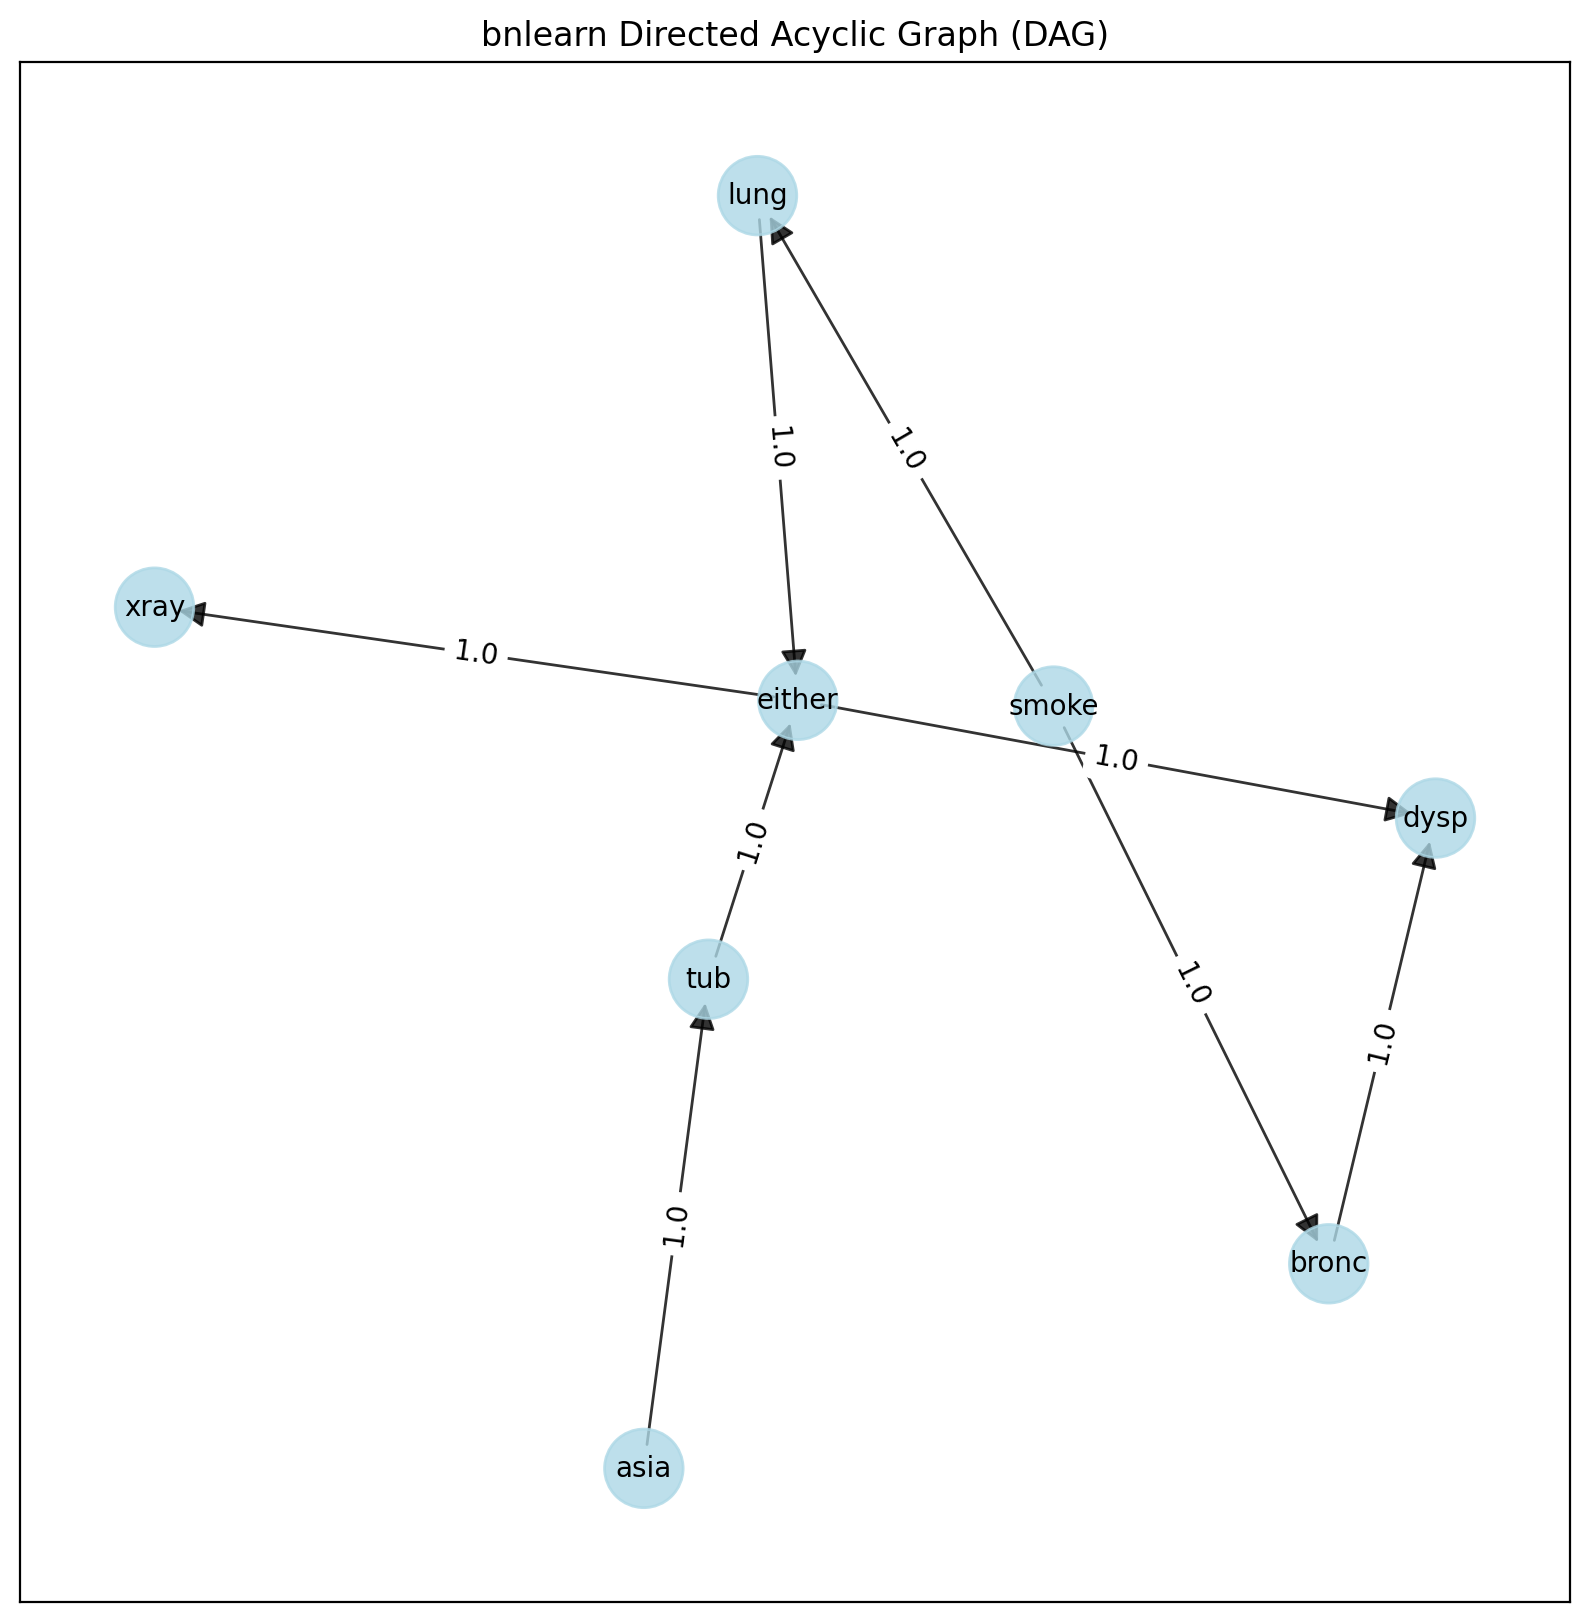

{'fig': <Figure size 2000x2000 with 1 Axes>,
 'ax': <Figure size 2000x2000 with 1 Axes>,
 'pos': {'asia': array([-0.30636383, -0.26820044]),
  'tub': array([-0.21476147, -0.05864694]),
  'either': array([-0.0881914,  0.0608414]),
  'smoke': array([0.27437717, 0.05837911]),
  'lung': array([-0.14529515,  0.27705324]),
  'bronc': array([ 0.66444494, -0.18055148]),
  'dysp': array([0.81578974, 0.01038634]),
  'xray': array([-1.        ,  0.10073879])},
 'G': <networkx.classes.digraph.DiGraph at 0x7f0b677d5b90>,
 'node_properties': {'asia': {'node_color': '#ADD8E6', 'node_size': 800},
  'tub': {'node_color': '#ADD8E6', 'node_size': 800},
  'smoke': {'node_color': '#ADD8E6', 'node_size': 800},
  'lung': {'node_color': '#ADD8E6', 'node_size': 800},
  'bronc': {'node_color': '#ADD8E6', 'node_size': 800},
  'either': {'node_color': '#ADD8E6', 'node_size': 800},
  'xray': {'node_color': '#ADD8E6', 'node_size': 800},
  'dysp': {'node_color': '#ADD8E6', 'node_size': 800}},
 'edge_properties': {('

In [1]:
import bnlearn as bn

# Load a predefined Bayesian network structure
asia_model = bn.import_DAG('asia')
bn.plot(asia_model)
#asia  tub  smoke  lung  bronc  either  xray  dysp
#{asia: (tub, either), tub: (lung, either), smoke: (lung, bronc), lung: (tub, either), bronc: (smoke, dysp), either: (tub, lung), xray: (lung, either), dysp: (bronc, either)}

In [2]:
# Simulate data from the model
asia_data = bn.sampling(asia_model, n=10000)

# Display the simulated dataset
print(asia_data.head())

   asia  tub  smoke  lung  bronc  either  xray  dysp
0     1    1      1     1      1       1     1     1
1     1    1      0     1      0       1     1     0
2     1    1      1     1      1       1     1     1
3     1    1      0     1      0       1     1     0
4     1    1      1     1      1       1     1     1


In [3]:
import pandas as pd

columns = ['0', '1', '2', '3', '4', '5', '6', '7']
data = [[2] *( len(columns)+0)]  # Each column has an arity of 2
df=pd.DataFrame(asia_data)
# Convert to DataFrame
df_arity = pd.DataFrame(data, columns=columns)
print(df.columns)
column_mapping = {old: new for old, new in zip(df.columns, df_arity.columns)}
df = df.rename(columns=column_mapping)

# Now, combine the data as before
df_combined_correct = pd.concat([df_arity, df], ignore_index=True)
df_combined_correct.to_csv("asia_dataset.csv", index=False)


# Combine the arity information (first row) with the rest of the dataset
df_combined_correct = pd.concat([df_arity, df])
# Save the DataFrame to a CSV file for inspection or future use
df_arity.to_csv("original_asia_dataset.csv", index=False)
# Append the arity row (df_arity) on top of the data_samples
df_combined = pd.concat([df_arity, df], ignore_index=True)

# Save the combined dataset to a CSV file
df_combined.to_csv("asia_dataset.dat", index=False, sep=' ')



Index(['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp'], dtype='object')


In [4]:
import subprocess

# Define the command as a list
command = [
    "python3",
    "./pygobnilp-1.0/rungobnilp.py",
    "./asia_dataset.dat",
    "--output_scores", "asia_scores.jkl",
    "--score", "BDeu",
    "--nopruning",
    "--end", "local scores"
]

# Specify the output file
output_file = "command_output.txt"

# Run the command and write its output to a file
with open(output_file, "w") as file:
    try:
        result = subprocess.run(command, check=True, text=True, stdout=file, stderr=subprocess.PIPE)
        print("Command executed successfully! Output written to", output_file)
    except subprocess.CalledProcessError as e:
        print("An error occurred while executing the command.")
        print("Error message:", e.stderr)


Command executed successfully! Output written to command_output.txt


In [26]:
import subprocess

# Define the command as a list of arguments
command = ["./modular-dag-sampling-master/sampler", "nonsymmetric", "asia_scores.jkl", "10000"]

# Specify the output file
output_file = "asia_sampled.txt"

# Run the command and write its output to the file
with open(output_file, "w") as file:
    try:
        result = subprocess.run(command, check=True, text=True, stdout=file, stderr=subprocess.PIPE)
        print("Command executed successfully! Output written to", output_file)
    except subprocess.CalledProcessError as e:
        print("An error occurred while executing the command.")
        print("Error message:", e.stderr)


Command executed successfully! Output written to asia_sampled.txt


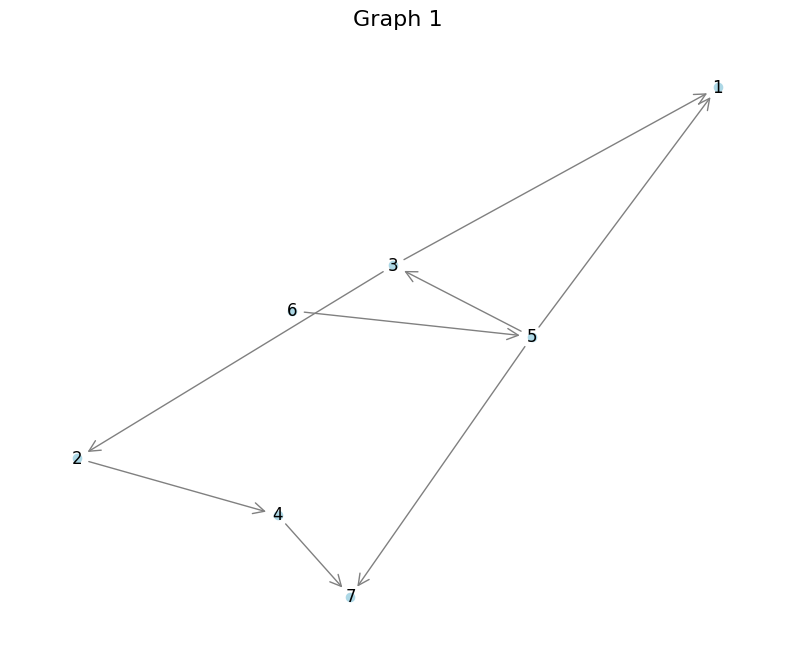

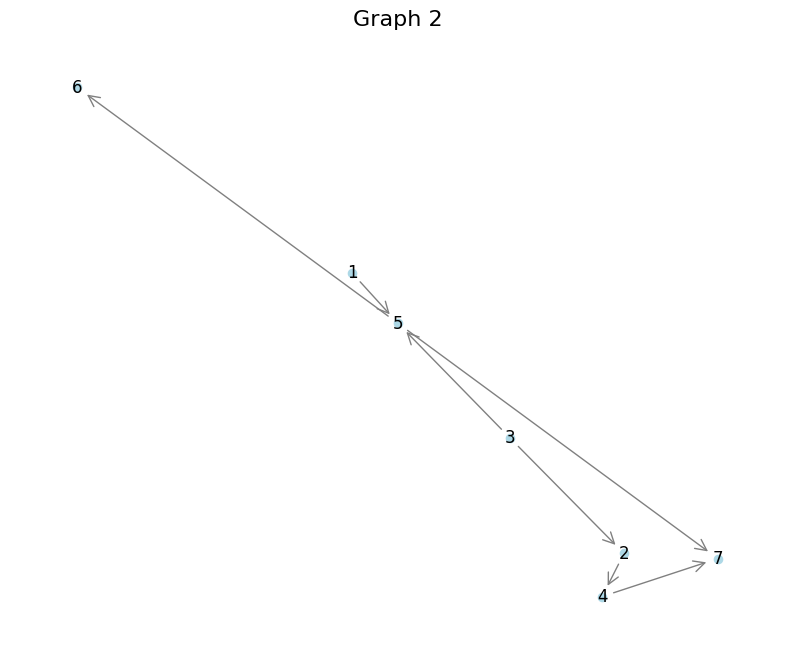

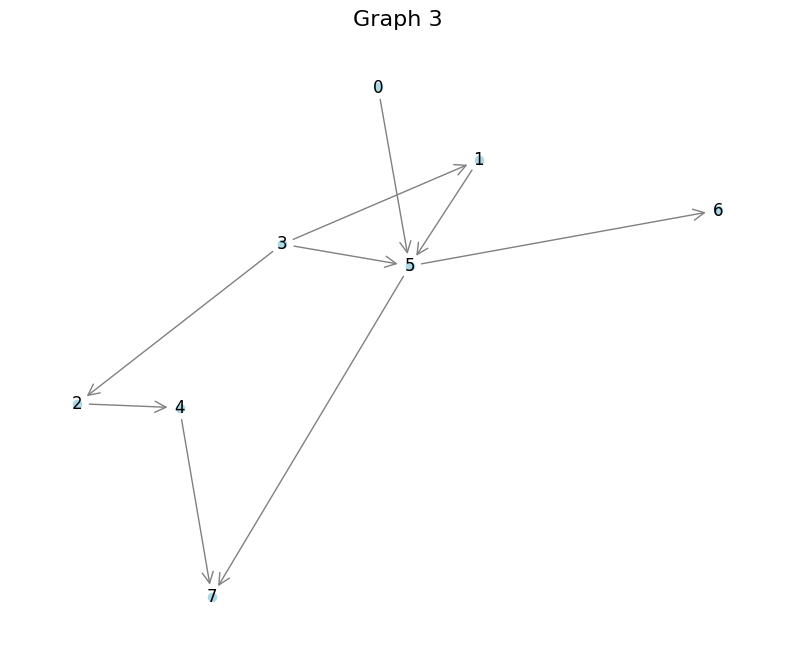

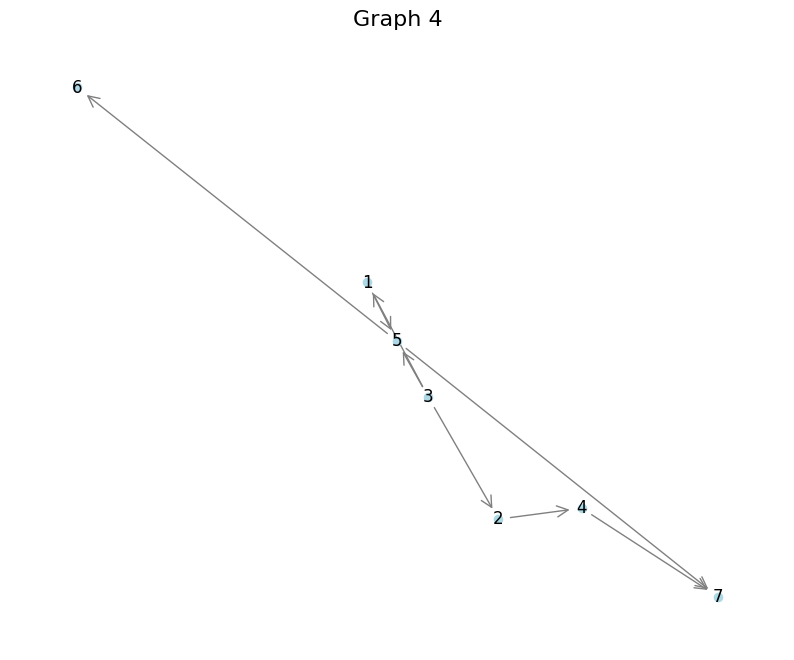

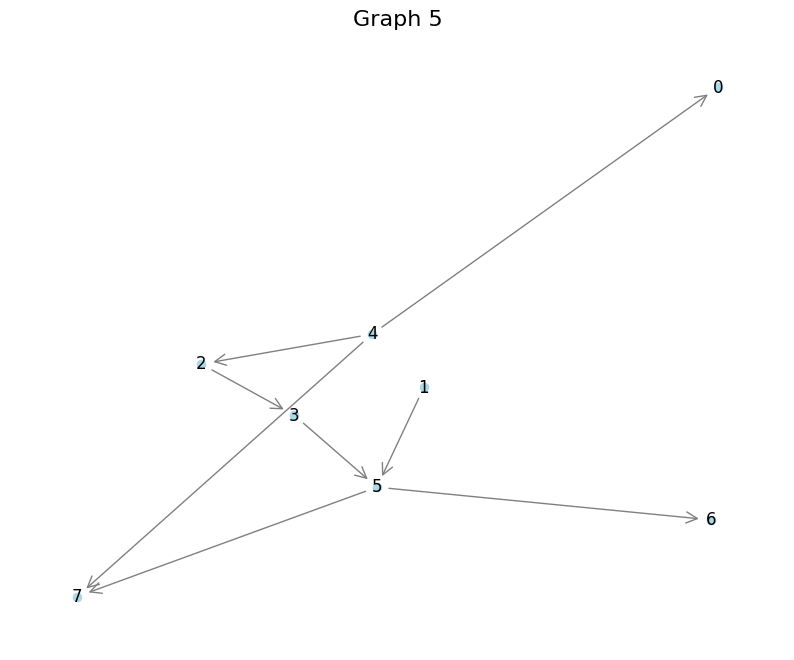

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def parse_bayes_graphs_from_file(file_path):
    """
    Parse multiple Bayesian graphs from a text file, where each line represents a separate graph.

    Args:
    file_path (str): Path to the text file.

    Returns:
    list: A list of NetworkX DiGraph objects, each representing a graph.
    """
    graphs = []
    with open(file_path, 'r') as file:
        for line in file:
            graph = nx.DiGraph()  # Create a directed graph
            node_relations = line.strip().split("},")  # Split each node relationship by commas
        
            node_relations= [item +"}"for item in node_relations]
            for relation in node_relations:
                if "<-" in relation:
                    node, parents = relation.split("<-")
                    node = node.strip()
                    parents = parents.strip().strip("{}").split(",")  # Extract parent nodes
                    parents = [p.strip() for p in parents if p.strip()]  # Clean up parent names
                    for parent in parents:
                        graph.add_edge(parent, node)  # Add directed edges
                else:
                    print(f"Skipping invalid relation: {relation}")
            graphs.append(graph)
    return graphs


def visualize_directed_graph(graph, title="Graph with Directed Edges"):
    """
    Visualize a NetworkX directed graph with clearly visible arrows.

    Args:
    graph (nx.DiGraph): The directed graph to visualize.
    title (str): Title for the graph.
    """
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph, seed=42)  # Use a spring layout for better visualization
    nx.draw_networkx_nodes(graph, pos, node_size=35, node_color="lightblue")
    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle="->", arrowsize=20, edge_color="gray")
    nx.draw_networkx_labels(graph, pos, font_size=12, font_color="black")
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()


# Path to the uploaded file
file_path = "asia_sampled.txt"

# Parse the Bayesian graphs from the file
parsed_graphs = parse_bayes_graphs_from_file(file_path)

# Visualize each graph
for i, graph in enumerate(parsed_graphs[:5], start=1):  # Visualize the first 5 graphs
    visualize_directed_graph(graph, title=f"Graph {i}")


In [7]:
import sumu.aps as aps
import numpy as np


from itertools import chain, combinations

def subsets(iterable, fromsize, tosize):
    s = list(iterable)
    step = 1 + (fromsize > tosize) * -2
    return chain.from_iterable(
        combinations(s, i) for i in range(fromsize, tosize + step, step)
    )
def greedy(
    K,
    *,
    scores,
    params={"K_f": 6, "t_budget": None, "association_measure": "score"},
    **kwargs,
):
    def _local(v, S, scores):
        """
        Compute the local score for a node `v` given a set of parent nodes `S`.

        Args:
        - v (int): Target node.
        - S (list): List of parent nodes.
        - scores (dict): Parsed scores from the .jkl file.

        Returns:
        - float: The score for the given node and parent set.
        """
        parent_set = tuple(S)
        for score, parents in scores.get(v, []):
            if parents == parent_set:
                return score
        return float('-inf')  # Return a very low score if not found

    k = params.get("K_f")
    if k is not None:
        k = min(k, K)
    t_budget = params.get("t_budget")
    association_measure = params.get("association_measure")
    assert association_measure in ("score", "gain")

    if association_measure == "score":
        goodness = lambda v, S, u: _local(v, S + [u], scores)
    elif association_measure == "gain":
        goodness = lambda v, S, u: _local(v, S + [u], scores) - _local(v, S, scores)

    def k_highest_uncovered(v, U, k):
        uncovereds = {
            u: max(
                {
                    goodness(v, S, u)
                    for S in subsets(
                        C[v],
                        0,
                        [
                            len(C[v])
                            if scores.get("maxid", -1) == -1
                            else min(len(C[v]), scores["maxid"] - 1)
                        ][0],
                    )
                }
            )
            for u in U
        }

        k_highest = list()
        while len(k_highest) < k:
            u_hat = max(uncovereds, key=lambda u: uncovereds[u])
            k_highest.append(u_hat)
            del uncovereds[u_hat]
        return k_highest

    # Example: Decide what to return
    # Assuming we want to compute something for all nodes
    result = {}
    for v in scores.keys():
        uncovered = list(range(K))  # Example placeholder for uncovered items
        result[v] = k_highest_uncovered(v, uncovered, k)
    
    return result



In [3]:
import os
print(os.getcwd())

/home/gulce/Downloads/thesis


In [2]:
def parse_gobnilp_jkl(file_path):
    """
    Parse the Gobnilp .jkl file format.

    Args:
    - file_path (str): Path to the .jkl file.

    Returns:
    - dict: Dictionary where keys are the number of parents and values are tuples of (score, parent_nodes).
    """
    scores = {}
    current_node = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue  # Skip empty lines

            parts = line.split()
            if len(parts) == 1 and parts[0].isdigit():
                # Metadata line (e.g., "8"), skip it
                continue
            elif len(parts) == 2 and not line.startswith("-"):
                # Node header line (e.g., "6 64")
                try:
                    current_node = int(parts[0])  # Node ID
                    scores[current_node] = []  # Initialize an empty list for this node
                except ValueError:
                    print(f"Unexpected node header: {line}")
            elif current_node is not None and len(parts) >= 2:
                # Score line, handle it
                try:
                    score = float(parts[0])  # First part is the score
                    num_parents = int(parts[1])  # Second part is the number of parents
                    parent_nodes = tuple(map(int, parts[2:])) if num_parents > 0 else ()
                    scores[current_node].append((score, parent_nodes))
                except ValueError:
                    print(f"Invalid score or parent set line: {line}")
            else:
                print(f"Unrecognized line: {line}")

    return scores






# Use the parser
parsed_scores = parse_gobnilp_jkl('asia_scores.jkl' )

In [3]:

import numpy as np

class Data:
    """Simple container for the number of variables n."""
    def __init__(self, n):
        self.n = n

class GobnilpScores:
    """
    A Scores-like class that wraps the output of parse_gobnilp_jkl 
    for use with sumu's candidate parent algorithms.
    """
    def __init__(self, parsed_scores):
        """
        Args:
            parsed_scores (dict): 
                A dict of { node: [ (score, (parents...)), ... ], ... }
        """
        self.n = max(parsed_scores.keys()) + 1
        self.data = Data(self.n)
        
        # Store local scores in { node: {parents_tuple: score} }
        self.local_scores = {}
        for node, sp_list in parsed_scores.items():
            self.local_scores[node] = {}
            for (score, parents) in sp_list:
                parents_sorted = tuple(sorted(parents))
                self.local_scores[node][parents_sorted] = score

        # If you do not have a known maximum parent set size, keep this -1
        self.maxid = -1

    def local(self, v, parents):
        """
        Sumu calls 'scores.local(...)' in the candidate generation.
        So, we must provide this method name exactly.
        """
        p_sorted = tuple(sorted(parents))
        return self.local_scores[v].get(p_sorted, float("-inf"))

    def all_candidate_restricted_scores(self, C):
        """
        Return a dictionary: node -> {parents_tuple: local_score},
        for parent sets that are subsets of C[node].
        Handles both dict and np.ndarray for C.
        """



        V = len(C)  # number of nodes
        # Suppose each node i has M_i subsets...
        # For it to be a uniform 2D array, you need the same number of columns for each node,
        # often 2^|C[i]| if you consider all subsets, or something that sumu’s "opt" expects.
        
        # Let's say we do the maximum number of subsets among all i
        max_subset_count = max(2 ** len(C[i]) for i in range(V))

        # Make a big 2D array for (V, max_subset_count)
        arr = np.full((V, max_subset_count), float("-inf"), dtype=float)

        # For each node i:
        for i in range(V):
            # Enumerate subsets of C[i] in some order
            # Suppose subsets_i is a list of (subset_tuple, score)
            subsets_i = []
            for parents_tuple, sc in self.local_scores[i].items():
                # only keep subsets that are within C[i]
                if set(parents_tuple).issubset(C[i]):
                    subsets_i.append((parents_tuple, sc))

            # Sort them in a stable order and store them
            # Typically sumu's "opt" uses bit-encodings, so you'd want j to match that encoding.
            # For simplicity, let's just do enumerated:
            for j, (parents_tuple, sc) in enumerate(subsets_i):
                arr[i, j] = sc

            # If subsets_i has fewer than max_subset_count, the rest remain -inf

        return arr



    def clear_cache(self):
        """If your scoring logic uses caching, clear it here; otherwise do nothing."""
        pass
    

# 1. Parse Gobnilp output
parsed_scores = parse_gobnilp_jkl("asia_scores.jkl")

# 2. Wrap into a sumu-compatible class
scores = GobnilpScores(parsed_scores)
import sumu
# 3. Choose an algorithm, e.g., "greedy", "optimal", or "random"
algo = sumu.candidate_parent_algorithm["greedy"]  # "opt", "random", "greedy", etc.

# 4. Build candidate parents, e.g., for K=2 
# (You can also pass them as is, or use some logic to define candidate sets).
K = 2

# Each algorithm expects certain arguments. For "greedy" we must pass `scores=...`
result = algo(K, scores=scores, params={"K_f": 6, "t_budget": None, "association_measure": "score"})
print(result)
from sumu.candidates import candidate_parent_algorithm as cpa

# Suppose you already have your 'scores' object that implements 'local(...)' etc.
#   from GobnilpScores or similar.

################################################################################
# 1. RANDOM
################################################################################


################################################################################
# 2. OPTIMAL
################################################################################

# 'opt' picks K parents that maximize the posterior probability
# that the true parent set is contained in C[v].
# It returns (candidate_parents_dict, None).
algo = cpa["opt"]

K = 2
candidate_parents= algo(
    K,
    scores=scores,    # Must pass in your scoring object
    n=scores.data.n,  # 'opt' also expects 'n' in kwargs
)
print("Optimal parents:", candidate_parents)




{0: (1, 3), 1: (3, 5), 2: (3, 4), 3: (1, 5), 4: (2, 7), 5: (1, 3), 6: (1, 5), 7: (4, 5)}
Optimal parents: {0: (1, 2), 1: (0, 2), 2: (0, 1), 3: (0, 1), 4: (0, 1), 5: (0, 1), 6: (0, 1), 7: (0, 1)}


In [10]:
from sumu.candidates import candidate_parent_algorithm as cpa
print(cpa.keys())


dict_keys(['opt', 'top', 'pc', 'mb', 'ges', 'greedy', 'greedy-lite', 'back-forth'])


In [11]:
import bnlearn as bn
asia_model = bn.import_DAG('asia')
asia_data = bn.sampling(asia_model, n=10000)

# Suppose X is your data, shape (N, n)
mydata = sumu.Data(asia_data.values, discrete=True)  # or discrete=False if continuous

algo = cpa["pc"]
candidate_parents= algo(
    K,

    data=mydata, # the underlying data object
       fill="random"
)
print("PC candidates:", candidate_parents)

[bnlearn] >Import <asia>
[bnlearn] >Loading bif file </home/gulce/.pyenv/versions/3.11.7/lib/python3.11/site-packages/datazets/data/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.


[setgraphviz] >INFO> cffi mode is CFFI_MODE.ANY
[setgraphviz] >INFO> R home found: /usr/lib/R
[setgraphviz] >INFO> R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/gulce/git/davon-lib/JAVA_LIBRARY/graalvm-ce-java8-20.3.3/lib/server
[setgraphviz] >INFO> LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/gulce/git/davon-lib/JAVA_LIBRARY/graalvm-ce-java8-20.3.3/lib/server
[setgraphviz] >INFO> Default options to initialize R: rpy2, --quiet, --no-save
[setgraphviz] >INFO> R is already initialized. No need to initialize.


PC candidates: {0: (1, 7), 1: (0, 5), 2: (3, 4), 3: (2, 5), 4: (2, 7), 5: (1, 3), 6: (1, 5), 7: (4, 5)}


In [5]:
import bnlearn as bn
asia_model = bn.import_DAG('asia')
asia_data = bn.sampling(asia_model, n=10000)

# Suppose X is your data, shape (N, n)
mydata = sumu.Data(asia_data.values, discrete=True)  # or discrete=False if continuous

algo = cpa["mb"]
candidate_parents= algo(
    K,

    data=mydata, # the underlying data object
       fill="random"
)
print("PC candidates:", candidate_parents)

[bnlearn] >Import <asia>
[bnlearn] >Loading bif file </home/gulce/.pyenv/versions/3.11.7/lib/python3.11/site-packages/datazets/data/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.


[setgraphviz] >INFO> cffi mode is CFFI_MODE.ANY
[setgraphviz] >INFO> R home found: /usr/lib/R
[setgraphviz] >INFO> R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/gulce/git/davon-lib/JAVA_LIBRARY/graalvm-ce-java8-20.3.3/lib/server
[setgraphviz] >INFO> LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/gulce/git/davon-lib/JAVA_LIBRARY/graalvm-ce-java8-20.3.3/lib/server
[setgraphviz] >INFO> Default options to initialize R: rpy2, --quiet, --no-save
[setgraphviz] >INFO> R is already initialized. No need to initialize.


PC candidates: {0: (1, 2, 3, 4, 5, 6, 7), 1: (0, 2, 3, 4, 5, 6, 7), 2: (0, 1, 3, 4, 5, 6, 7), 3: (0, 1, 2, 4, 5, 6, 7), 4: (0, 1, 2, 3, 5, 6, 7), 5: (0, 1, 2, 3, 4, 6, 7), 6: (0, 1, 2, 3, 4, 5, 7), 7: (0, 1, 2, 3, 4, 5, 6)}


In [13]:
algo = cpa["back-forth"]
K = 2
candidate_parents = algo(
    K,
    scores=scores,
    data=scores.data
)
print("Back-forth candidates:", candidate_parents)

Back-forth candidates: {0: (1, 3), 1: (3, 5), 2: (4, 6), 3: (1, 5), 4: (2, 7), 5: (1, 3), 6: (1, 5), 7: (4, 5)}


In [6]:
algo = cpa["ges"]
K = 7
candidate_parents = algo(
    K,
    scores=scores,
    data=mydata,
    fill="top"
)
print("Back-forth candidates:", candidate_parents)

Back-forth candidates: {0: (1, 2, 3, 4, 5, 6, 7), 1: (0, 2, 3, 4, 5, 6, 7), 2: (0, 1, 3, 4, 5, 6, 7), 3: (0, 1, 2, 4, 5, 6, 7), 4: (0, 1, 2, 3, 5, 6, 7), 5: (0, 1, 2, 3, 4, 6, 7), 6: (0, 1, 2, 3, 4, 5, 7), 7: (0, 1, 2, 3, 4, 5, 6)}


In [10]:
def parse_dag_line(line: str) -> dict:
    """
    Given a line like:
      "0 <- {}, 1 <- {3}, 2 <- {3}, 3 <- {}, 4 <- {2}, 5 <- {1, 3}, 6 <- {5}, 7 <- {4, 5}"
    return a dict:
      {0: set(), 1: {3}, 2: {3}, 3: set(), 4: {2}, 5: {1,3}, 6: {5}, 7: {4,5}}
    """
    dag = {}
    
    # 1) Split by "}," to separate each node's parent specification
    chunks = line.split("},")
    
    for chunk in chunks:
        chunk = chunk.strip()
        if not chunk:
            continue  # skip empty pieces (can happen if line ends with "},")
        
        # 2) Ensure the chunk ends with "}" if it doesn't already
        if not chunk.endswith("}"):
            chunk += "}"
        
        # Now chunk should look like, for example: "0 <- {}", or "1 <- {3}"
        if "<-" not in chunk:
            # If there's no "<-", it's not valid for our parser;
            # skip or raise an error, as you prefer.
            continue
        
        node_str, parents_str = chunk.split("<-")
        node_str = node_str.strip()        # e.g. "0"
        parents_str = parents_str.strip()  # e.g. "{3}" or "{}"
        
        # 3) Remove the outer braces from parents_str
        if parents_str.startswith("{"):
            parents_str = parents_str[1:]
        if parents_str.endswith("}"):
            parents_str = parents_str[:-1]
        
        # 4) Parse the parent nodes inside the braces
        parents_str = parents_str.strip()
        if parents_str:
            # e.g. "1, 3" -> ["1", "3"] -> {1, 3}
            parent_list = [p.strip() for p in parents_str.split(",") if p.strip()]
            parents = set(int(p) for p in parent_list)
        else:
            parents = set()
        
        # Convert node_str to int (assuming your node labels are numeric)
        node = int(node_str)
        
        # Store in the DAG dict
        dag[node] = parents
    
    return dag

def parse_dag_file(file_path: str) -> list:
    """
    Read the file line by line. Each line describes one DAG,
    and parse it into a dict: { node: set_of_parents, ... }.
    
    Returns a list of such dicts, e.g. [dag1, dag2, dag3, ...].
    """
    all_dags = []
    with open(file_path, 'r') as f:
        for line_no, line in enumerate(f, start=1):
            line = line.strip()
            if not line:
                continue  # skip empty lines

            dag = parse_dag_line(line)
            if dag:
                # If your line is valid, append it
                all_dags.append(dag)
            else:
                # You can decide how to handle an empty / invalid parse
                print(f"Warning: line {line_no} didn't parse to a DAG, skipping.")
    
    return all_dags


def print_dags_as_code(dags):
    """
    Given a list of DAG dicts, print them in a 'Python code' format like:

        # DAG #1
        sampled_dags.append({
            0: set(),
            1: {3, 5},
            ...
        })

    so you can copy & paste easily into a Python script.
    """
    for i, dag in enumerate(dags, start=1):
        print(f"# DAG #{i}")
        print("sampled_dags.append({")
        for node in sorted(dag.keys()):
            parents = dag[node]
            # Convert the Python set into a string like {3, 5} or set()
            if len(parents) == 0:
                parents_str = "set()"
            else:
                # e.g. parents = {3, 5}, we want "{3, 5}"
                # sorted list for stable output
                sorted_parents = sorted(parents)
                parents_str = "{" + ", ".join(map(str, sorted_parents)) + "}"
            
            print(f"    {node}: {parents_str},")
        print("})\n")


if __name__ == "__main__":
    # Example usage:
    # 1. Parse the file into a list of DAGs
    filename = "asia_sampled.txt"
    sampled_dags = parse_dag_file(filename)
    
    # # 2. Print them as Python code
    # print_dags_as_code(sampled_dags)


In [11]:

# Suppose your “Back-forth candidates” mean that for node i,
# the candidate parents are exactly this set.




def coverage_fraction(candidate_parents, sampled_dags):
    """
    Returns the fraction of sampled DAGs whose parent sets
    are all subsets of candidate_parents[node].
    """
    count_covered = 0
    total = len(sampled_dags)
    
    for dag in sampled_dags:
        covered = True
        for node, parents in dag.items():
            # If the DAG's parents for this node go beyond what
            # the candidate set allows, it's not covered
            if not parents.issubset(candidate_parents[node]):
                covered = False
                break
        if covered:
            count_covered += 1
    
    return count_covered / total if total > 0 else 0.0
fraction = coverage_fraction(candidate_parents, sampled_dags)
print("Coverage fraction =", fraction)
print("Coverage percentage = {:.1f}%".format(fraction * 100))


Coverage fraction = 1.0
Coverage percentage = 100.0%
